In [ ]:
!pip install advertools datasets transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 14.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using c

In [ ]:
!nvidia-smi

Sat Jun  8 05:16:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   40C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import spacy
import advertools as adv
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')

from datasets import load_dataset

import numpy as np
import pandas as pd
import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
from torch.utils.data import TensorDataset, Subset, Dataset
from torch.nn.parallel import DistributedDataParallel as DDP

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:datasets:PyTorch version 2.3.0+cu121 available.
INFO:datasets:Polars version 0.20.2 available.
INFO:datasets:TensorFlow version 2.15.0 available.
INFO:datasets:JAX version 0.4.26 available.


In [ ]:
# Detect if we have a GPU available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device:{device}')

print(torch.cuda.get_device_properties(device))

Device:cuda
_CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22699MB, multi_processor_count=58)


In [ ]:
# Load stopwords
filipino_stop_words = set(adv.stopwords['tagalog'])
print(f'Nuber of Filipino Stop Words: {len(filipino_stop_words)}')
english_stop_words = set(adv.stopwords['english'])
print(f'Number of English Stop Words: {len(english_stop_words)}')
stopwords = filipino_stop_words.union(english_stop_words)
stopwords.update(['si', 'naman', 'kay', 'ayon', 'noong', 'rin', 'lang', 'nang', 'mo', 'kayo'])
print(f'Number of Stop Words: {len(stopwords)}')

Nuber of Filipino Stop Words: 147
Number of English Stop Words: 305
Number of Stop Words: 459


In [ ]:
np.array(english_stop_words)

array({'we', 'how', 'just', 'ours', 'your', 'anywhere', 'did', 'by', 'often', 'after', 'under', 'below', 'amount', 'hereupon', 'whole', 'sometime', 'everyone', 'to', 'had', 'that', 'also', 'thence', 'until', 'throughout', 'really', 'it', 'be', 'towards', 'former', 'and', 'per', 'somehow', 'whereas', 'beside', 'amongst', 'yet', 'thereafter', 'two', 'own', 'regarding', 'used', 'cannot', 'they', 'myself', 'eleven', 'moreover', 'but', 'their', 'whereby', 'keep', 'during', 'go', 'herself', 'full', 'using', 're', 'else', 'take', 'either', 'once', 'she', 'say', 'these', 'meanwhile', 'latterly', 'yourself', 'always', 'any', 'becoming', 'give', 'behind', 'in', 'will', 'around', 'while', 'about', 'name', 'himself', 'you', 'as', 'again', 'still', 'both', 'this', 'which', 'indeed', 'being', 'within', 'already', 'via', 'almost', 'please', 'see', 'whereupon', 'not', 'whoever', 'thus', 'on', 'an', 'beyond', 'twelve', 'nowhere', 'toward', 'seeming', 'several', 'back', 'now', 'put', 'whereafter', 'amon

In [ ]:
np.array(filipino_stop_words)

array({'marapat', 'isang', 'likod', 'aming', 'nito', 'namin', 'ilagay', 'anumang', 'kumuha', 'panahon', 'paggawa', 'ni', 'tulad', 'nais', 'pagkakaroon', 'nila', 'bawat', 'gumawa', 'siya', 'dahil', 'ginawang', 'ay', 'din', 'kanya', 'naging', 'nasaan', 'na', 'kaya', 'gayunman', 'ang', 'gagawin', 'bago', 'lima', 'itaas', 'lamang', 'kanila', 'masyado', 'nagkaroon', 'bakit', 'kailangan', 'apat', 'pababa', 'aking', 'kanilang', 'ng', 'paraan', 'sila', 'hanggang', 'napaka', 'mismo', 'kahit', 'muli', 'bababa', 'maging', 'amin', 'iyon', 'karamihan', 'maaari', 'pumupunta', 'iyong', 'paano', 'ilalim', 'noon', 'katulad', 'iyo', 'narito', 'sino', 'sarili', 'ibaba', 'ginawa', 'pareho', 'ka', 'pero', 'ilan', 'gusto', 'inyong', 'kung', 'sa', 'pa', 'kaysa', 'ginagawa', 'ito', 'katiyakan', 'ibabaw', 'isa', 'kami', 'dito', 'saan', 'mayroon', 'pumunta', 'kanino', 'nakita', 'laban', 'pagitan', 'atin', 'may', 'walang', 'maaaring', 'nabanggit', 'lahat', 'una', 'kanyang', 'ikaw', 'niya', 'bilang', 'pataas', 'h

In [ ]:
# Load the dataset
dataset = load_dataset('jcblaise/fake_news_filipino', trust_remote_code=True)
print(dataset)

# Convert to pandas dataframe
df = pd.DataFrame(dataset['train'])
df.head()

Generating train split:   0%|          | 0/3206 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'article'],
        num_rows: 3206
    })
})


,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


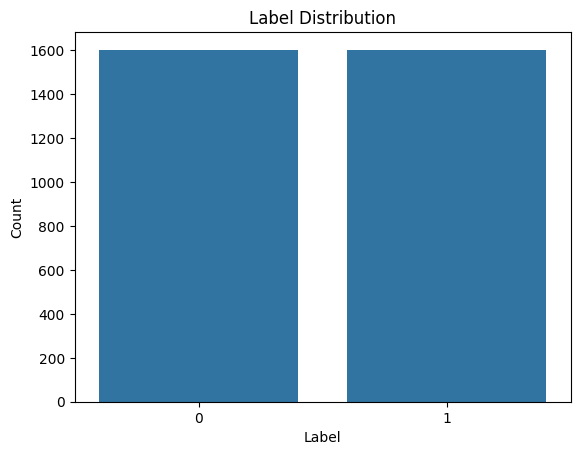

In [ ]:
# Check label distribution
label_counts = df['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
fake_news = df[df['label'] == 1]
true_news = df[df['label'] == 0]

# Display information about the different labels
fake_news.info()
true_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1603 entries, 1603 to 3205
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1603 non-null   int64 
 1   article  1603 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1603 entries, 0 to 1602
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1603 non-null   int64 
 1   article  1603 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [ ]:
# Concatenates all text for each category
text = ' '.join(df['article'].tolist()).lower()
fake_text = ' '.join(fake_news['article'].tolist()).lower()
true_text = ' '.join(true_news['article'].tolist()).lower()

In [ ]:
# Find most common words
words = word_tokenize(text)
fake_words = word_tokenize(fake_text)
true_words = word_tokenize(true_text)

filtered_words = [word for word in words if word.isalnum() and word not in stopwords]
filtered_fake_words = [word for word in fake_words if word.isalnum() and word not in stopwords]
filtered_true_words = [word for word in true_words if word.isalnum() and word not in stopwords]

common_words = Counter(filtered_words).most_common(20)
common_fake_words = Counter(filtered_fake_words).most_common(20)
common_true_words = Counter(filtered_true_words).most_common(20)

print("Most common words from...")
print("All News:", common_words)
print("Fake News:", common_fake_words)
print("True News:", common_true_words)

Most common words from...
All News: [('duterte', 1605), ('daw', 1571), ('umano', 1195), ('ilang', 1113), ('source', 1062), ('video', 957), ('sinabi', 950), ('po', 895), ('natin', 883), ('pilipinas', 882), ('matapos', 878), ('pangulong', 870), ('miss', 856), ('city', 830), ('media', 761), ('catriona', 740), ('manila', 707), ('wala', 686), ('pangulo', 654), ('pahayag', 642)]
Fake News: [('duterte', 1566), ('daw', 1497), ('umano', 1067), ('source', 1043), ('ilang', 942), ('video', 923), ('miss', 847), ('pangulong', 813), ('po', 798), ('natin', 781), ('pilipinas', 760), ('catriona', 735), ('media', 678), ('pangulo', 579), ('kababayan', 569), ('gray', 565), ('pageant', 563), ('manila', 546), ('social', 540), ('matapos', 527)]
True News: [('sinabi', 428), ('upang', 399), ('city', 356), ('matapos', 351), ('sina', 304), ('pang', 266), ('taon', 221), ('bansa', 218), ('national', 217), ('wala', 216), ('nasa', 207), ('dalawang', 207), ('mas', 204), ('unang', 204), ('kasama', 189), ('philippine', 

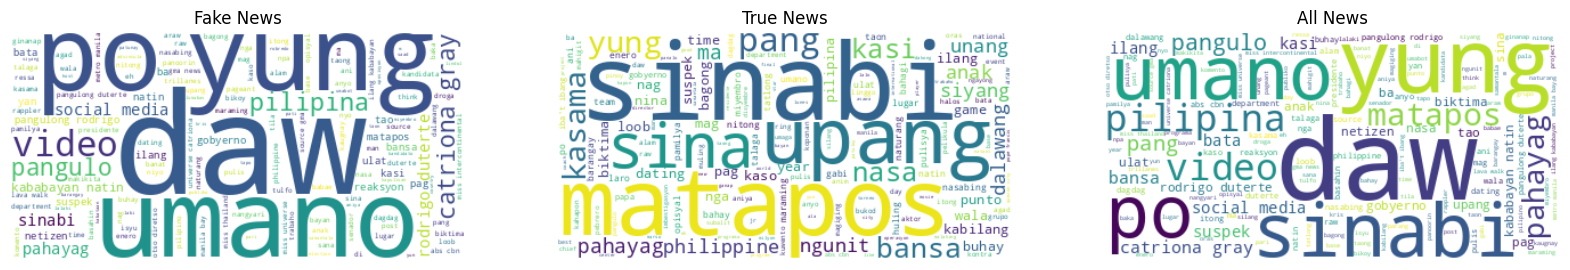

In [ ]:
# Generate word clouds for each category
all_wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)
fake_wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(fake_text)
true_wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(true_text)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(fake_wordcloud, interpolation='bilinear')
axs[0].set_title('Fake News')
axs[0].axis('off')
axs[1].imshow(true_wordcloud, interpolation='bilinear')
axs[1].set_title('True News')
axs[1].axis('off')
axs[2].imshow(all_wordcloud, interpolation='bilinear')
axs[2].set_title('All News')
axs[2].axis('off')
plt.show()

Label: 0
Max length of the text: 965
Mean length of the text: 121.39426076107299


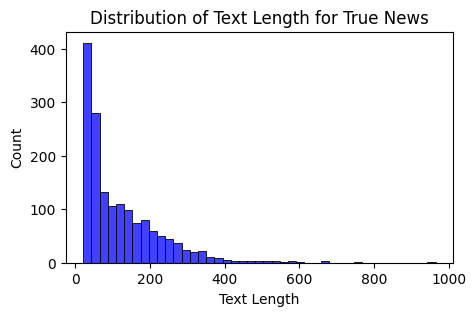

Label: 1
Max length of the text: 1074
Mean length of the text: 244.05864004990642


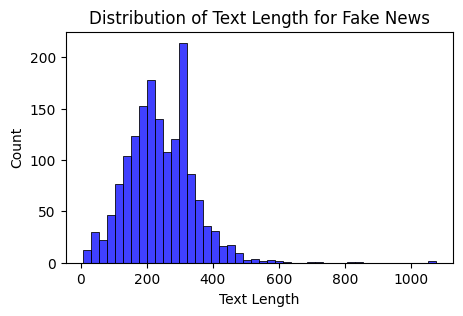

In [ ]:
labels = df['label'].unique()
label_dict = {0: "True News", 1: "Fake News"}

for label in labels:
    words = [text for text in df[df['label'] == label]['article']]

    max_len = 0
    text_len = []

    for texts in words:
        text_len.append(len(texts.split()))
        max_len = max(len(texts.split()), max_len)

    print(f'Label: {label}')
    print('Max length of the text:', max_len)
    print('Mean length of the text:', np.mean(text_len))

    plt.figure(figsize=(5, 3))
    sns.histplot(text_len, kde=False, color='blue')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.title(f'Distribution of Text Length for {label_dict[label]}')
    plt.show()

Data Preprocessing

In [ ]:
df.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [ ]:
# Split dataset
X = df['article']
y = df['label']

In [ ]:
# Loads the BERT tokenizer outside the loops
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
# Encodes the dataset
encodings = tokenizer(list(X), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# batch_sizes = [8, 16, 32, 48, 64]
batch_sizes = [32]
# workers = [0, 1, 2, 3, 4, 5, 6, 7, 8]
worker = 2

learning_rates = [0.00006]
# learning_rate = 1e-5
num_epochs = [2]
#epoch = 3

k_folds = 3
results = []

#model = DDP(model)

for learning_rate in learning_rates:
#for worker in workers:
  for batch_size in batch_sizes:
    for epoch in num_epochs:

      kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=20)

      for fold, (train_ids, val_ids) in enumerate(kfold.split(X, y)):

        # Creates custom datasets
        train_encodings = {key: [val[i] for i in train_ids] for key, val in encodings.items()}
        val_encodings = {key: [val[i] for i in val_ids] for key, val in encodings.items()}
        train_labels = [y[i] for i in train_ids]
        val_labels = [y[i] for i in val_ids]

        train_dataset = CustomDataset(train_encodings, train_labels)
        val_dataset = CustomDataset(val_encodings, val_labels)

        # Loads the model and move it to the GPU if available
        model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to(device)
        model_name = 'BERT'

        print(f"Training {model_name} with lr={learning_rate}, batch size={batch_size}, epochs={epoch} and fold={fold}...")

        training_args = TrainingArguments(
            output_dir = f'./results/BERT/gpu/fold_{fold}', # The output directory where the model predictions and checkpoints will be written
            evaluation_strategy = "epoch",                  # The evaluation strategy to adopt during training. "epoch": done at the end of each epoch
            per_device_train_batch_size = batch_size,       # Batch size per GPU/XPU/TPU/MPS/NPU core/CPU for training.
            per_device_eval_batch_size = batch_size,        # Batch size per GPU/XPU/TPU/MPS/NPU core/CPU for evaluation.
            num_train_epochs = epoch,                       # Total number of training epochs to perform.
            learning_rate = learning_rate,                  # The initial learning rate for AdamW optimizer.
            weight_decay = 0.01,                            # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
            logging_dir = f'./logs/BERT/gpu/fold_{fold}',   # TensorBoard log directory
            logging_steps = 10,                             # Number of update steps between two logs if logging_strategy="steps".

            #MIXED PRECISION TRAINING
            fp16=True,                                     # Mixed precision training uses both 16-bit and 32-bit floating point types, reducing memory usage and improving computational efficiency, which speeds up training.

            #GRADIENT ACCUMULATION
            #gradient_accumulation_steps=4,                 # Accumulate gradients

            #GRADIENT CHECKPOINTING
            #gradient_checkpointing=True,

            #DATA PRE LOADING
            dataloader_pin_memory=True,
            dataloader_num_workers = worker,                    # Set number of workers for data loading

            #TORCH COMPILING
            #torch_compile=True,

            #OPTIMIZER CHOICE
            #optim="adafactor",

            report_to = "none",
            no_cuda = False)

        #data_collator = DataCollatorWithPadding(tokenizer)

        trainer = Trainer(
            model = model,
            args = training_args,
            train_dataset = train_dataset,
            eval_dataset = val_dataset,
            #tokenizer = tokenizers,
            #data_collator = data_collator,
            compute_metrics = compute_metrics)

        start_mem_allocated = torch.cuda.memory_allocated() / (1024 * 1024)
        start_mem_reserved = torch.cuda.memory_reserved() / (1024 * 1024)

        start_time = time.time()
        trainer.train()
        end_time = time.time()

        end_mem_allocated = torch.cuda.memory_allocated() / (1024 * 1024)
        end_mem_reserved = torch.cuda.memory_reserved() / (1024 * 1024)

        eval_results = trainer.evaluate()

        results.append({
          'model': model_name,
          'descrption': f'workers_{worker}',
          'learning_rate': learning_rate,
          'batch_size': batch_size,
          'epochs': epoch,
          'fold': fold + 1,

          'training_time': end_time - start_time,

          'accuracy': eval_results['eval_accuracy'],
          'f1': eval_results['eval_f1'],
          'precision': eval_results['eval_precision'],
          'recall': eval_results['eval_recall'],
          'loss': eval_results['eval_loss'],

          'memory_allocated_before_train': start_mem_allocated,
          'memory_reserved_before_train': start_mem_reserved,

          'memory_allocated_after_train': end_mem_allocated,
          'memory_reserved_after_train': end_mem_reserved})


results_df_fin = pd.DataFrame(results)
results_df_fin.to_csv('df_fin.csv', index=False)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT with lr=6e-05, batch size=32, epochs=2 and fold=0...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.280000,0.220935,0.910196,0.907869,0.931102,0.885768
2,0.092500,0.163270,0.943873,0.943609,0.947170,0.940075


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT with lr=6e-05, batch size=32, epochs=2 and fold=1...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.257600,0.168879,0.933583,0.934562,0.921818,0.947664
2,0.154100,0.161596,0.954163,0.954419,0.950000,0.958879


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT with lr=6e-05, batch size=32, epochs=2 and fold=2...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.303600,0.356578,0.884831,0.894962,0.822606,0.981273
2,0.142300,0.168689,0.933521,0.933953,0.927911,0.940075


In [ ]:
results_df_learn = pd.DataFrame(results)
results_df_learn.to_csv('df_learn.csv', index=False)

In [ ]:
results_df_learn

,model,descrption,learning_rate,batch_size,epochs,fold,training_time,accuracy,f1,precision,recall,loss,memory_allocated_before_train,memory_reserved_before_train,memory_allocated_after_train,memory_reserved_after_train
0,BERT,workers_2,0.00006,32,2,1,74.721376,0.943873,0.943609,0.947170,0.940075,0.163270,678.735840,734.0,2060.678223,7948.0
1,BERT,workers_2,0.00006,32,2,2,77.149900,0.954163,0.954419,0.950000,0.958879,0.161596,2756.149414,7948.0,4122.327148,10590.0
2,BERT,workers_2,0.00006,32,2,3,76.898973,0.933521,0.933953,0.927911,0.940075,0.168689,4817.923340,10590.0,4136.422852,10350.0
